Build a model to forecast the demand(passenger traffic) in Airplanes.

Loading the basic libraries

In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA  

Loading AirPassenger data set

In [162]:
airpass = pd.read_csv("AirPassengers.csv")

airpass.head(5)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [163]:
airpass.tail(5)

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [164]:
airpass.rename(columns={'#Passengers':'Passengers'},inplace=True)
airpass.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [165]:
airpass.shape

(144, 2)

In [166]:
airpass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


Need to convert Month column in to datetime datatype.

In [167]:
from datetime import datetime
airpass['Month']=pd.to_datetime(airpass['Month'],infer_datetime_format=True)

airpass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


Now, we will need to index Month column.

In [168]:
airpassind = airpass.set_index('Month',inplace=False)

airpassind.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Let's plot the data

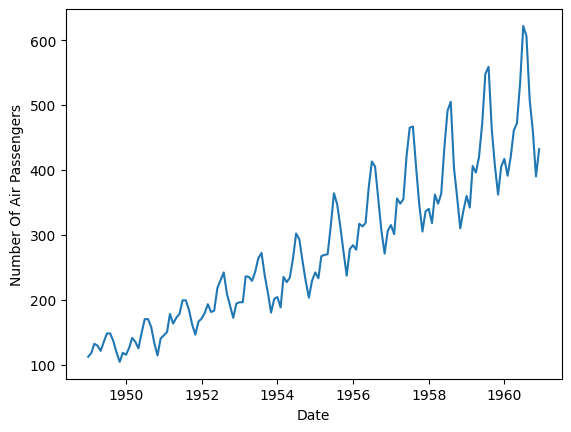

In [169]:
plt.xlabel('Date')
plt.ylabel('Number Of Air Passengers')
plt.plot(airpassind)

From the above plot, we can see that there is a "Trend compoenent" in the series. Hence, we will now check for stationarity of the data.


Let's make one function consisting of stationary data checking and ADCF test working. Because we will need to repeat the steps many times, therefore, making function will become very handy

In [170]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    airpass_test = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(airpass_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in airpass_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Let's determine & plot rolling statistics

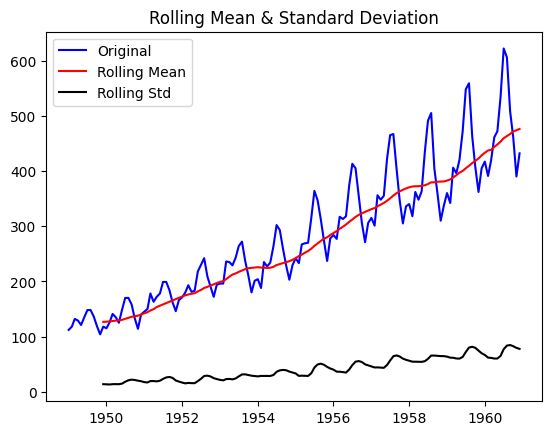

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [171]:
test_stationarity(airpassind)

Data Transformation To Achieve Stationarity

Let us perform Log Transformation.

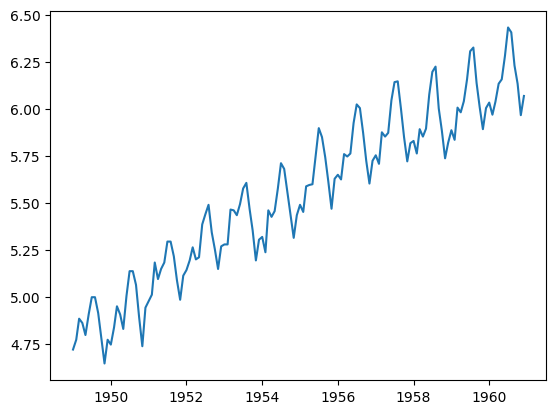

In [172]:
airpass_log = np.log(airpassind)

plt.plot(airpass_log)

Working on Rolling stats seperately (not using function) because we would need Rolling stats separately for computing

In [173]:
rollmean_log = airpass_log.rolling(window=12).mean()
rollstd_log = airpass_log.rolling(window=12).std()

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation (Logarithmic Scale)')

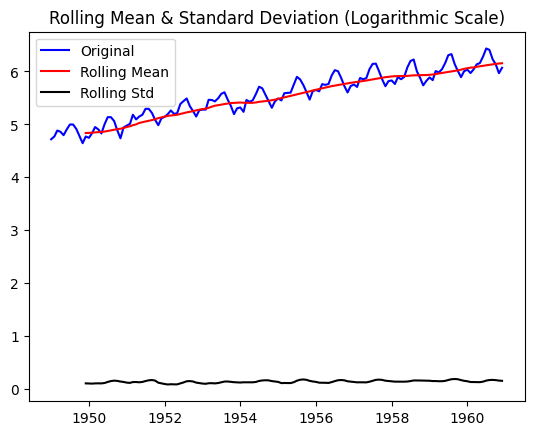

In [174]:
plt.plot(airpass_log, color='blue', label='Original')
plt.plot(rollmean_log, color='red', label='Rolling Mean')
plt.plot(rollstd_log, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Logarithmic Scale)')

From the above graph, Time series with log scale as well as Rolling Mean(moving avg) both have the trend component. Thus subtracting one from the other should remove the trend component.

In [175]:
airpass_new = airpass_log - rollmean_log

airpass_new.head()

,Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


In [176]:
airpass_new.dropna(inplace=True)

airpass_new.head()

,Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


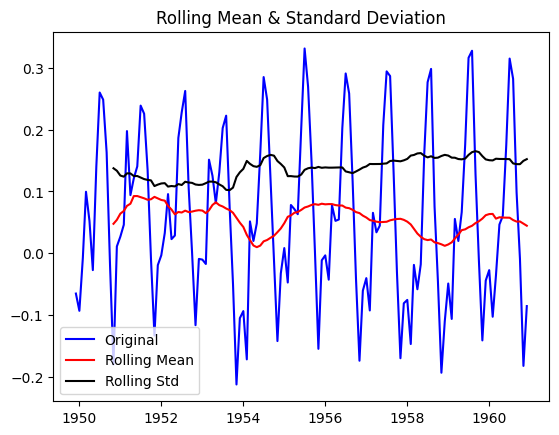

Results of Dickey Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [177]:
test_stationarity(airpass_new)

1. p-value has reduced from 0.99 to 0.022

2. Critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic

So we can now say that given series is now STATIONARY

Time Shift Transformation

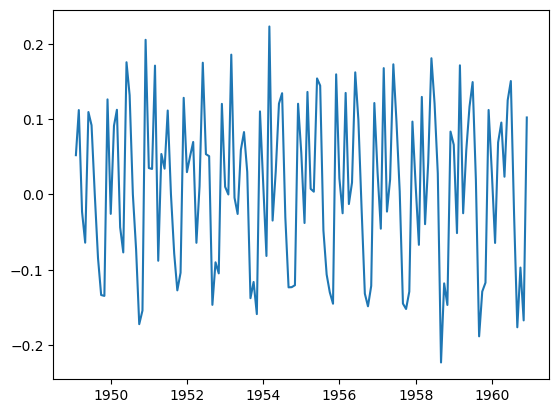

In [178]:
airpass_log_diff = airpass_log - airpass_log.shift()
plt.plot(airpass_log_diff)

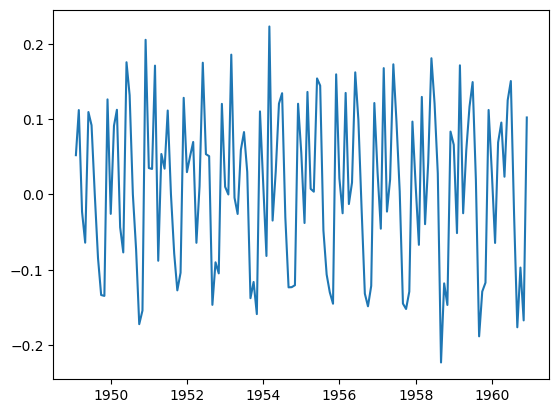

In [179]:
airpass_log_diff.dropna(inplace=True)
plt.plot(airpass_log_diff)

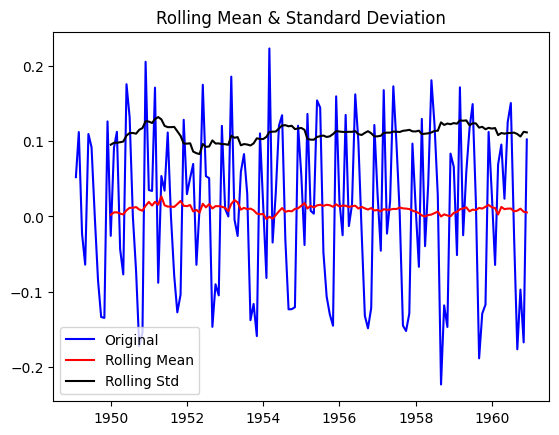

Results of Dickey Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [180]:
test_stationarity(airpass_log_diff)

From above plot, we can see that, visually this is the very best result as our series along with rolling stats values of moving avg(mean) & moving standard deviation is very much flat & stationary.


But, the ADCF test shows us that:


p-value of 0.07 is not as good as 0.02 of previous instance.

Test Statistic value not as close to the critical values as that of previous instance.

Plotting ACF & PACF

In [181]:
lag_acf = acf(airpass_log_diff, nlags=20)
lag_pacf = pacf(airpass_log_diff, nlags=20, method='ols')

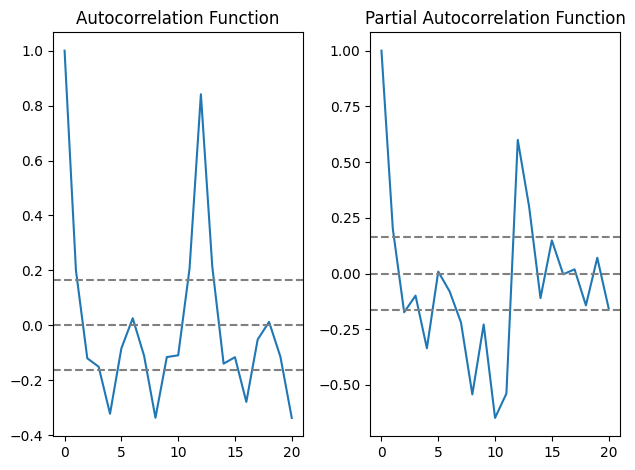

In [182]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function') 

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(airpass_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

ARIMA Model

Making order = (2,1,2)

Plotting ARIMA model


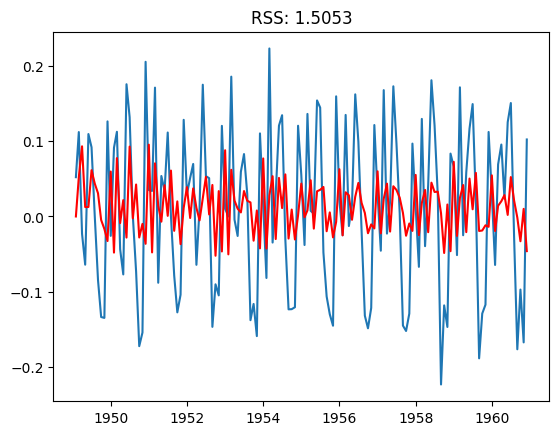

In [183]:
model = ARIMA(airpass_log_diff, order=(2,1,2))
results_ARIMA = model.fit()
plt.plot(airpass_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - airpass_log_diff['Passengers'])**2))
print('Plotting ARIMA model')

Prediction & Reverse Transformation

In [184]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.000000
1949-03-01    0.052186
1949-04-01    0.093194
1949-05-01    0.012531
1949-06-01    0.012598
dtype: float64

In [185]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.000000
1949-03-01    0.052186
1949-04-01    0.145380
1949-05-01    0.157911
1949-06-01    0.170509
dtype: float64

In [186]:
predictions_ARIMA_log = pd.Series(airpass_log['Passengers'].iloc[0], index=airpass_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.770685
1949-04-01    4.863879
1949-05-01    4.876410
dtype: float64

Inverse of log is exp

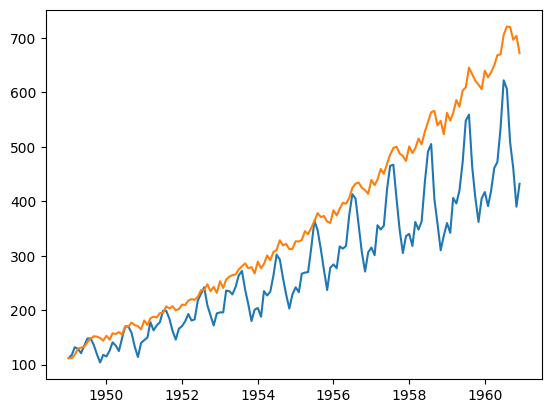

In [187]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(airpassind)
plt.plot(predictions_ARIMA)